# Speech Emotion Recognition

## Dataset: [RAVDESS](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio)

### Extracting the data

In [1]:
import os

DATA_DIR = "dataset/"

files = []
for filename in os.listdir(DATA_DIR):
    for audio_file in os.listdir(DATA_DIR + filename):
        files.append(filename + "/" + audio_file)

print(len(files))


1440


In [2]:
# extracting the class labels i.e the emotion
labels = []
for filename in files:
    emotion = filename.split('/')[1].split('.')[0].split('-')[2]
    labels.append(emotion)

print(len(labels))

1440


In [3]:
class_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [4]:
new_labels = [class_map[label] for label in labels]

In [5]:
import pandas as pd

dataframe = dict(zip(files, new_labels))
df = pd.DataFrame(list(dataframe.items()), columns=['filename', 'emotion'])
df.head()


,filename,emotion
0,Actor_05/03-01-07-02-02-01-05.wav,disgust
1,Actor_05/03-01-05-02-01-01-05.wav,angry
2,Actor_05/03-01-04-02-02-02-05.wav,sad
3,Actor_05/03-01-04-01-02-01-05.wav,sad
4,Actor_05/03-01-06-02-01-01-05.wav,fearful


In [6]:
df.to_csv('dataset.csv', index=False)

### Exploratory Data Analysis

In [7]:
df['emotion'].value_counts()

emotion
disgust      192
angry        192
sad          192
fearful      192
surprised    192
calm         192
happy        192
neutral       96
Name: count, dtype: int64

It is a fairly balanced dataset

There are two statements spoken by the voice actors: "Kids are talking by the door" and "Dogs are sitting by the door"

In [8]:
for i in range(0, len(df)):
    filename = df.loc[i, 'filename']
    line_spoken = filename.split('/')[1].split('.')[0].split('-')[4]
    df.loc[i, 'line'] = line_spoken
    

In [9]:
df['line'].value_counts()

line
02    720
01    720
Name: count, dtype: int64

Both lines spoken equally even among the different emotions

In [10]:
df.groupby(['emotion', 'line']).size()

emotion    line
angry      01      96
           02      96
calm       01      96
           02      96
disgust    01      96
           02      96
fearful    01      96
           02      96
happy      01      96
           02      96
neutral    01      48
           02      48
sad        01      96
           02      96
surprised  01      96
           02      96
dtype: int64

Emotional Intensity:

In [11]:
for i in range(0, len(df)):
    filename = df.loc[i, 'filename']
    intensity = filename.split('/')[1].split('.')[0].split('-')[3]
    df.loc[i, 'intensity'] = intensity
    

In [12]:
df['intensity'].value_counts()

intensity
01    768
02    672
Name: count, dtype: int64

Fairly balanced in this aspect as well

But we are not using the type of line or the emotional intensity for classification, so we may ignore these columns.

In [13]:
df.drop(columns=['intensity', 'line'], inplace=True)

## Audio Visualisation

In [14]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import random

In [15]:
def waveplot(path_to_audio, emotion):
    plt.figure(figsize=(10, 3))
    data, sampling_rate = librosa.load(path_to_audio)
    plt.title(emotion)
    librosa.display.waveshow(data, sr=sampling_rate, color="blue")

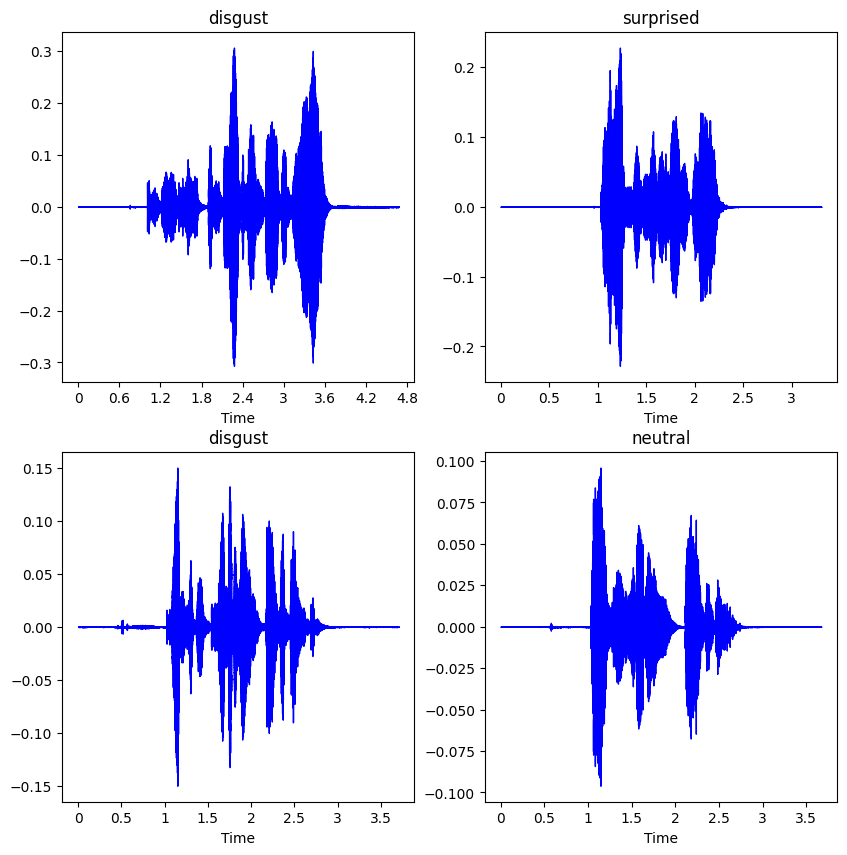

In [16]:

# plot  4 waveplots in a grid
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    index = random.randint(0, len(df))
    data, sampling_rate = librosa.load(DATA_DIR + df.loc[index, 'filename'])
    plt.title(df.loc[index, 'emotion'])
    librosa.display.waveshow(data, sr=sampling_rate, color="blue")

## Feature Extraction

1. Mel-spectrogram
2. Mel-Frequency Ceptral Coefficients (MFCC)
3. Short-time Fourier Transform (STFT)

## Mel-Spectrogram

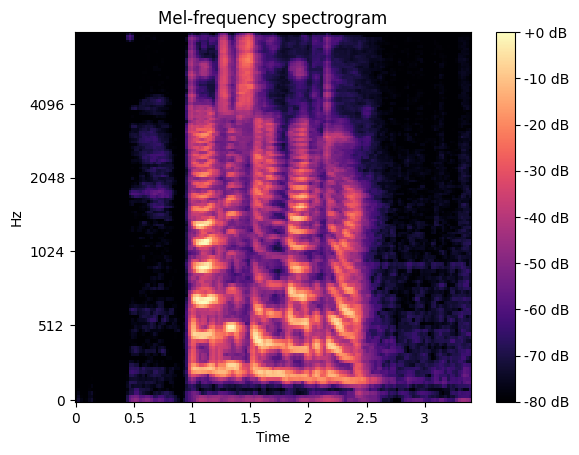

In [17]:
data, sampling_rate = librosa.load('dataset/Actor_06/03-01-01-01-02-01-06.wav')
S = librosa.feature.melspectrogram(y=data, sr=sampling_rate)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sampling_rate, fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
plt.show()

In [18]:
# creating the mel-spectrogram for all audio files

def create_mel_spectrogram(file_path):
    y, sr = librosa.load(file_path, duration=3)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

df['filename'] = df['filename'].apply(lambda x: 'dataset/'+x)

mel_spectrograms = []
for i in df['filename']:
    mel_spectrograms.append(create_mel_spectrogram(i))

In [19]:
# the list contains some spectrograms which have irregular shapes, so we remove them and their corresponding emotion labels

mismatched_indices = [i for i in range(len(mel_spectrograms)) if mel_spectrograms[i].shape != (128, 130)]
filtered_emotions = [i for j, i in enumerate(df['emotion']) if j not in mismatched_indices]
filtered_mel_spectrogram = [i for i in mel_spectrograms if i.shape == (128, 130)]
len(filtered_mel_spectrogram)


1438

In [20]:
# applying standardization

mel_spectrograms =  np.array(filtered_mel_spectrogram)
mel_spectrograms = mel_spectrograms.reshape(mel_spectrograms.shape[0], 128, 130, 1)

mean = np.mean(mel_spectrograms)
std = np.std(mel_spectrograms)
mel_spectrograms = (mel_spectrograms - mean) / std

### Model building and training

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


In [23]:
class_mapping = {
    'neutral': 0,
    'calm': 1,
    'happy': 2,
    'sad': 3,
    'angry': 4,
    'fearful': 5,
    'disgust': 6,
    'surprised': 7
}

In [24]:
y = [class_mapping[i] for i in filtered_emotions]

In [25]:
# splitting hte data into training and testing

X = mel_spectrograms
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

In [26]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([1150, 128, 130, 1]) torch.Size([1150]) torch.Size([288, 128, 130, 1]) torch.Size([288])


In [27]:
# reshaping the data so that model recognizes that it is a single-channeled image

X_train = X_train.reshape(X_train.shape[0], 1, 128, 130)
X_test = X_test.reshape(X_test.shape[0], 1, 128, 130)

In [29]:
# using gpu if available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [30]:
# building the model

class CNN(nn.Module):
    def __init__(self):
            super().__init__()
            self.network = nn.Sequential(
                
                nn.Conv2d(1, 32, kernel_size = 3, padding = 1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
                nn.ReLU(),
                nn.MaxPool2d(2,2),
                
                nn.Flatten(),
                nn.Linear(32768,1024),
                nn.ReLU(),
                nn.Linear(1024, 512),
                nn.ReLU(),
                nn.Linear(512, 8)
            )
        
    def forward(self, x):
        return self.network(x)
    
model = CNN()
model = model.to(device)
print(model)

CNN(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=32768, out_features=1024, bias=True)
    (11): ReLU()
    (12): Linear(in_features=1024, out_features=512, bias=True)
    (13): ReLU()
    (14): Linear(in_features=512, out_features=8, bias=True)
  )
)


In [31]:
def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    return train_dataloader

In [32]:
# training

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 40
batch_size = 32

train_data = TensorDataset(X_train, y_train)
train_loader = create_data_loader(train_data, batch_size)

/home/shail/Projects/Speech_emotion_recognition/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
torch.cuda.empty_cache()

In [34]:
from tqdm import tqdm

for e in range(epochs):
    running_loss = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        print(f"Epoch [{e+1}] Training loss: {running_loss/len(train_loader)}")

  0%|          | 0/36 [00:00<?, ?it/s]/home/shail/Projects/Speech_emotion_recognition/env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 36/36 [00:01<00:00, 24.09it/s]


Epoch [1] Training loss: 2.0678242875470056


100%|██████████| 36/36 [00:01<00:00, 26.27it/s]


Epoch [2] Training loss: 1.7937941948572795


100%|██████████| 36/36 [00:01<00:00, 26.32it/s]


Epoch [3] Training loss: 1.5653384228547413


100%|██████████| 36/36 [00:01<00:00, 26.25it/s]


Epoch [4] Training loss: 1.274884131219652


100%|██████████| 36/36 [00:01<00:00, 26.22it/s]


Epoch [5] Training loss: 0.9704706817865372


100%|██████████| 36/36 [00:01<00:00, 26.17it/s]


Epoch [6] Training loss: 0.7262766924169328


100%|██████████| 36/36 [00:01<00:00, 26.13it/s]


Epoch [7] Training loss: 0.5348877525991864


100%|██████████| 36/36 [00:01<00:00, 26.11it/s]


Epoch [8] Training loss: 0.35488302757342655


100%|██████████| 36/36 [00:01<00:00, 26.18it/s]


Epoch [9] Training loss: 0.25359808715681237


100%|██████████| 36/36 [00:01<00:00, 26.15it/s]


Epoch [10] Training loss: 0.21266373867789903


100%|██████████| 36/36 [00:01<00:00, 26.10it/s]


Epoch [11] Training loss: 0.16887020278308126


100%|██████████| 36/36 [00:01<00:00, 26.19it/s]


Epoch [12] Training loss: 0.13038840879582697


100%|██████████| 36/36 [00:01<00:00, 26.15it/s]


Epoch [13] Training loss: 0.11974387984567632


100%|██████████| 36/36 [00:01<00:00, 26.10it/s]


Epoch [14] Training loss: 0.05051333460465281


100%|██████████| 36/36 [00:01<00:00, 26.12it/s]


Epoch [15] Training loss: 0.013998550095291447


100%|██████████| 36/36 [00:01<00:00, 25.97it/s]


Epoch [16] Training loss: 0.008937203734401718


100%|██████████| 36/36 [00:01<00:00, 26.02it/s]


Epoch [17] Training loss: 0.010917004389436139


100%|██████████| 36/36 [00:01<00:00, 26.04it/s]


Epoch [18] Training loss: 0.005488429281184735


100%|██████████| 36/36 [00:01<00:00, 26.10it/s]


Epoch [19] Training loss: 0.0009503148677241472


100%|██████████| 36/36 [00:01<00:00, 26.07it/s]


Epoch [20] Training loss: 0.00036705878210341325


100%|██████████| 36/36 [00:01<00:00, 26.02it/s]


Epoch [21] Training loss: 0.00023709653861361503


100%|██████████| 36/36 [00:01<00:00, 26.08it/s]


Epoch [22] Training loss: 0.00019228886185373995


100%|██████████| 36/36 [00:01<00:00, 26.02it/s]


Epoch [23] Training loss: 0.00015967594233896106


100%|██████████| 36/36 [00:01<00:00, 26.03it/s]


Epoch [24] Training loss: 0.00013533448408351332


100%|██████████| 36/36 [00:01<00:00, 26.06it/s]


Epoch [25] Training loss: 0.00011565284648895613


100%|██████████| 36/36 [00:01<00:00, 26.05it/s]


Epoch [26] Training loss: 9.899955501977174e-05


100%|██████████| 36/36 [00:01<00:00, 25.98it/s]


Epoch [27] Training loss: 8.440308892608705e-05


100%|██████████| 36/36 [00:01<00:00, 25.86it/s]


Epoch [28] Training loss: 7.274942906102903e-05


100%|██████████| 36/36 [00:01<00:00, 25.88it/s]


Epoch [29] Training loss: 6.263593220662895e-05


100%|██████████| 36/36 [00:01<00:00, 25.96it/s]


Epoch [30] Training loss: 5.5025222385059656e-05


100%|██████████| 36/36 [00:01<00:00, 26.00it/s]


Epoch [31] Training loss: 4.870469749423339e-05


100%|██████████| 36/36 [00:01<00:00, 26.07it/s]


Epoch [32] Training loss: 4.355005090575206e-05


100%|██████████| 36/36 [00:01<00:00, 26.06it/s]


Epoch [33] Training loss: 3.925595547116245e-05


100%|██████████| 36/36 [00:01<00:00, 26.00it/s]


Epoch [34] Training loss: 3.573004624336641e-05


100%|██████████| 36/36 [00:01<00:00, 26.01it/s]


Epoch [35] Training loss: 3.2625517506959215e-05


100%|██████████| 36/36 [00:01<00:00, 25.93it/s]


Epoch [36] Training loss: 3.011198185100107e-05


100%|██████████| 36/36 [00:01<00:00, 25.89it/s]


Epoch [37] Training loss: 2.7706764891869778e-05


100%|██████████| 36/36 [00:01<00:00, 25.85it/s]


Epoch [38] Training loss: 2.571964696724333e-05


100%|██████████| 36/36 [00:01<00:00, 25.92it/s]


Epoch [39] Training loss: 2.381078858585776e-05


100%|██████████| 36/36 [00:01<00:00, 25.94it/s]

Epoch [40] Training loss: 2.2211222080335978e-05


In [35]:
test_data = TensorDataset(X_test, y_test)
test_loader = create_data_loader(test_data, batch_size)

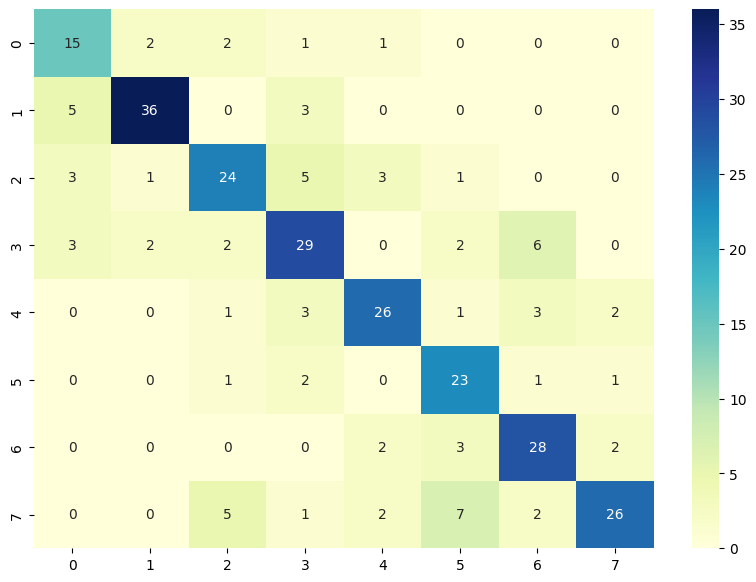

In [36]:
# confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

y_pred = []
y_true = []

with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in range(8)], columns = [i for i in range(8)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
plt.show()


In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.71      0.64        21
           1       0.88      0.82      0.85        44
           2       0.69      0.65      0.67        37
           3       0.66      0.66      0.66        44
           4       0.76      0.72      0.74        36
           5       0.62      0.82      0.71        28
           6       0.70      0.80      0.75        35
           7       0.84      0.60      0.70        43

    accuracy                           0.72       288
   macro avg       0.72      0.72      0.71       288
weighted avg       0.73      0.72      0.72       288



## We achieve an accuracy of 70% from training a 2D CNN on the mel-spectrograms of the audio.